In [1]:
from pinn import PINN, Trainer
import torch
import numpy as np
from pinn.utils import *

# Wave Equation
We want to solve the one-dimensional wave equation that is given by:
\begin{equation}
\frac{\partial^2 h}{\partial t^2} = c^2 \frac{\partial^2 h}{\partial x^2}
\end{equation}


We shall give the initial conditions $h(x, t=0)$ and $du(x, t=0)/dt$ with Dirichlet boundary condition at $x = -1,+1$. The PINN model should predicts $h(x, t)$ for the input $(x, t)$.

Here, the chosen conditions are,
$$
\begin{aligned}
h(-1, t) & =0 \\
h(1, t) & =0 \\
h(x, 0) & =u(x) \\
\left.\frac{\partial h(x, t)}{\partial t}\right|_{t=0} & =v(x)
\end{aligned}
$$

where $h(0, x)=sin(kx - \omega t) \cdot exp(-(kx - \omega t)^2) $, and $\frac{\partial h(x, t)}{\partial t}$ is the derivative of $h(x, t)$ with respect to $t$ that is evaluated at $t=0$. In this example, let asuume $c=1$.

where \( h \) represents the displacement of the wave, \( t \) represents time, \( x \) represents position along the direction of wave propagation, and \( c \) represents the wave speed.


In [2]:
def wave_equation(u,du_dx,du_dxx,du_dt,du_dtt):
    left = du_dtt
    right = 1**2 * du_dxx # C = 1
    return left,right

## Generate Data
For the wave equation, we need to generate the data for the initial condition, boundary condition, and collocation points. The initial condition is given by \( h(x, 0) \) and \( \frac{\partial h(x, 0)}{\partial t} \). The boundary condition is given by \( h(-1, t) \) and \( h(1, t) \). The collocation points are randomly sampled points in the domain of the solution. The function `generate_data` generates the data for the wave equation. The function takes the following arguments:

In [3]:
# Constants
x_start = -1
x_end = 1
t_start = 0
t_end = 4
C = 1
K = 2
W = K*C

In [4]:
def f0(X_ic):
    x ,t = X_ic[:,0], X_ic[:,1]
    y_0 = torch.sin(K*x - (C*K)*t) * torch.exp(-(K*x - (C*K)*t) ** 2)
    return y_0

In [5]:
def generate_data(N_0, N_b, N_f ,f0, x_start, x_end, t_start, t_end, dy_ic_dx = False):
    """
    Generate the training data.
    N_0: Number of initial condition points.
    N_b: Number of boundary condition points.
    N_f: Number of collocation points.
    f0: Initial condition function.
    x_start: Start of the x domain.
    x_end: End of the x domain.
    t_start: Start of the t domain.
    t_end: End of the t domain.
    dy_ic_dx: If True, the function returns the derivative of the initial condition with respect to x.

    """

    #Sampling for collocation points
    X_f = torch.rand(N_f, 2)
    # lhs returns samples that are uniformly distributed in the unit square (between 0 and 1) we want to scale them so that they are in the domain of the solution
    X_f[:, 0] = X_f[:, 0] * (x_end- x_start) + x_start
    X_f[:, 1] = X_f[:, 1] * (t_end- t_start) + t_start
    # cast to torch tensor
    X = torch.Tensor(X_f)

    # Boundary condition points
    bc = torch.rand(N_b, 2)
    bc[..., 1] = t_end*bc[..., 1]
    bc[..., 0] = 2*torch.round(bc[..., 0])-1 
    y_bc = torch.zeros(bc.shape[0])


    # Initial condition points
    x_i = torch.linspace(x_start, x_end, N_0)
    t_i = torch.zeros(N_0)
    ic = torch.stack([x_i, t_i], dim=1)
    y_ic = f0(ic)

    

    if dy_ic_dx:
        ic_clone = ic.clone()
        ic_clone.requires_grad = True
        y_ic_clone = f0(ic_clone)
        # derivative of the initial condition with respect to x
        dy_ic_dX = torch.autograd.grad(f0(ic_clone), ic_clone, grad_outputs=torch.ones_like(y_ic_clone), create_graph=True, retain_graph=True)[0]
        dy_ic_dx = dy_ic_dX[:,0].detach()
        #dy_ic_dt = dy_ic_dX[:,1] # this is sparse (all t equal to 0)

    else:
        dy_ic_dx = None

    return X,bc,ic,y_bc,y_ic,dy_ic_dx

X shape: torch.Size([10000, 2]),
bc shape: torch.Size([100, 2]),
ic shape: torch.Size([100, 2]),
y_bc shape: torch.Size([100]),
y_ic shape: torch.Size([100])


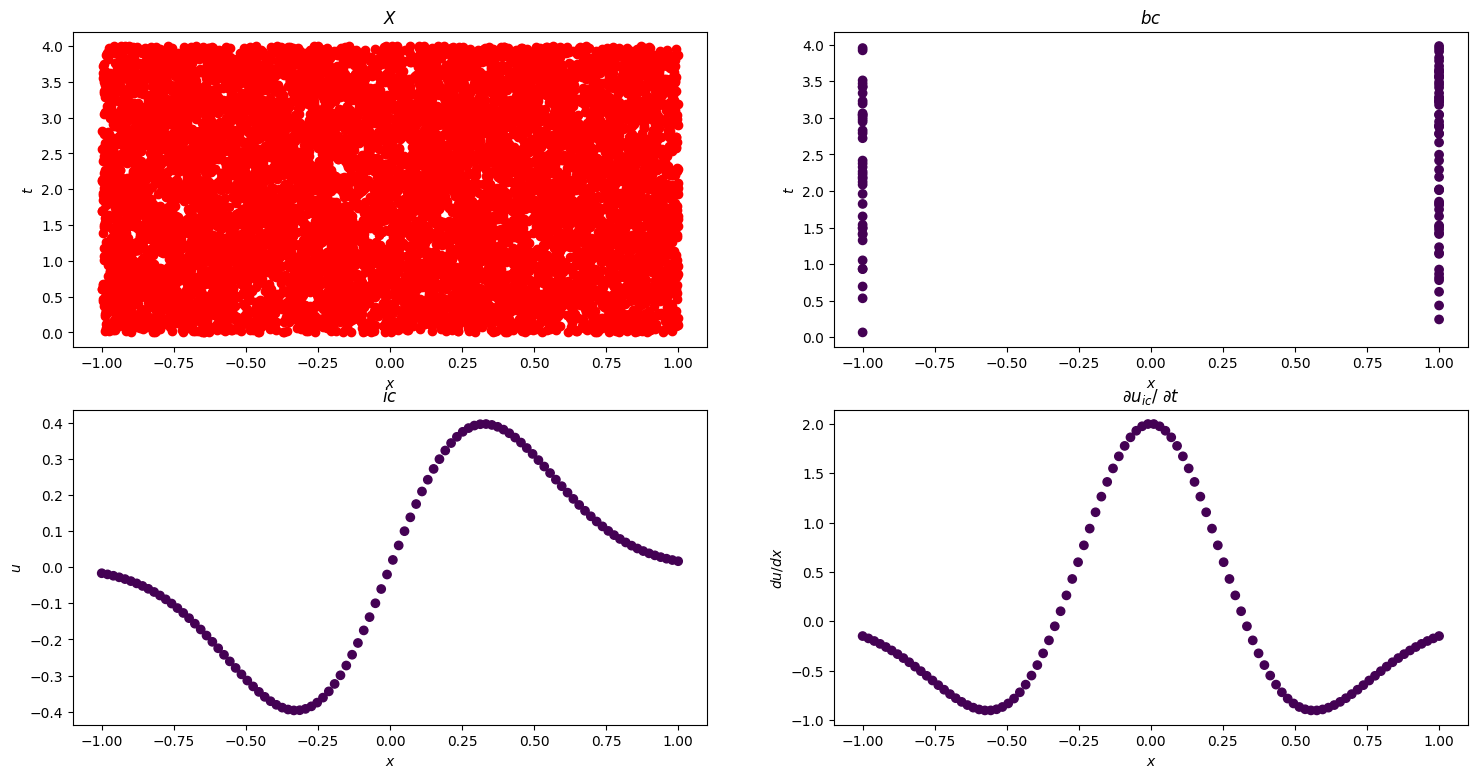

In [6]:
N_0 = 100
N_b = 100
N_f = 10000
X,bc,ic,y_bc,y_ic,dy_ic_dx = generate_data(N_0, N_b, N_f,f0=f0, x_start=x_start, x_end=x_end, t_start=t_start, t_end=t_end, dy_ic_dx = True)
print(f"X shape: {X.shape}," "\n"
      f"bc shape: {bc.shape}," "\n"
      f"ic shape: {ic.shape}," "\n"
      f"y_bc shape: {y_bc.shape}," "\n"
      f"y_ic shape: {y_ic.shape}" "\n"
      )

f = plot_data(X, bc, y_bc, ic, y_ic, dy_ic_dx)

## Train the model

In [7]:
trainer = Trainer(model= PINN([20,20,20,20],
                          lb= torch.tensor([x_start, t_start]),
                          ub= torch.tensor([x_end, t_end])),
            X = X,
            X_bc = bc,
            X_ic = ic,
            y_bc = y_bc,
            y_ic = y_ic,
            pde = wave_equation,
            dy_ic_dx = dy_ic_dx,
            )
history = trainer.train(adam_epochs=1000, lbfgs_epochs=5000)

Iteration: 100, Loss: 0.87537682056427 , Loss BC: 0.0023718071170151234, Loss IC: 0.860075831413269, Loss PDE: 0.012929224409162998
Iteration: 200, Loss: 0.020173730328679085 , Loss BC: 0.01011782418936491, Loss IC: 0.008456720039248466, Loss PDE: 0.00159918621648103
Iteration: 300, Loss: 0.012761307880282402 , Loss BC: 0.009290048852562904, Loss IC: 0.002870558761060238, Loss PDE: 0.0006007006741128862
Iteration: 400, Loss: 0.010981892235577106 , Loss BC: 0.009165873751044273, Loss IC: 0.0013236554805189371, Loss PDE: 0.0004923635278828442
Iteration: 500, Loss: 0.010344946756958961 , Loss BC: 0.009085141122341156, Loss IC: 0.0008131664944812655, Loss PDE: 0.00044663858716376126
Iteration: 600, Loss: 0.010097798891365528 , Loss BC: 0.009041892364621162, Loss IC: 0.0006150681874714792, Loss PDE: 0.0004408383392728865
Iteration: 700, Loss: 0.009998468682169914 , Loss BC: 0.009030037559568882, Loss IC: 0.0004707682819571346, Loss PDE: 0.0004976619966328144
Iteration: 800, Loss: 0.00987714

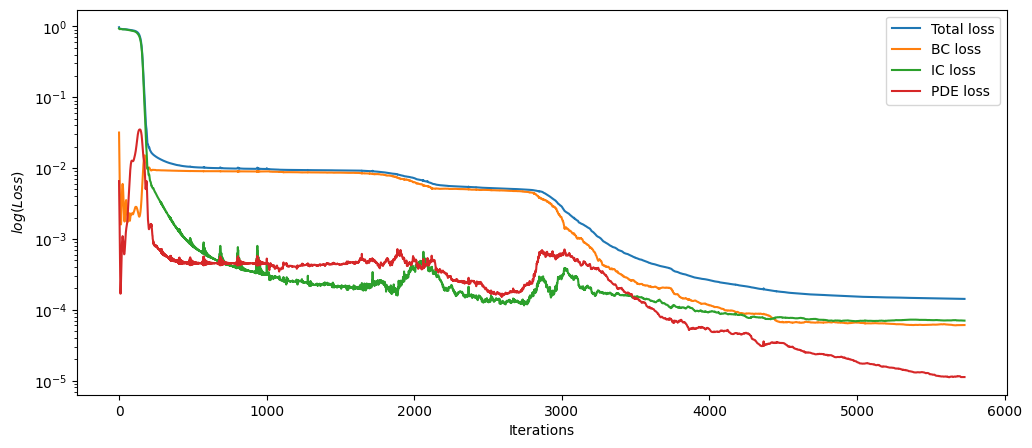

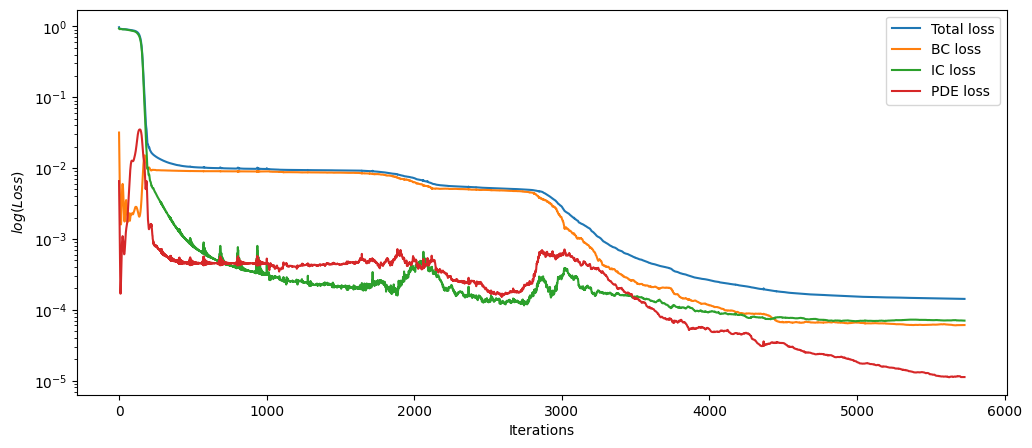

In [8]:
plot_learning_curve(history)

In [9]:
model = trainer.model
model.eval()

PINN(
  (scaling_layer): Sequential(
    (0): Scale()
  )
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
  )
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

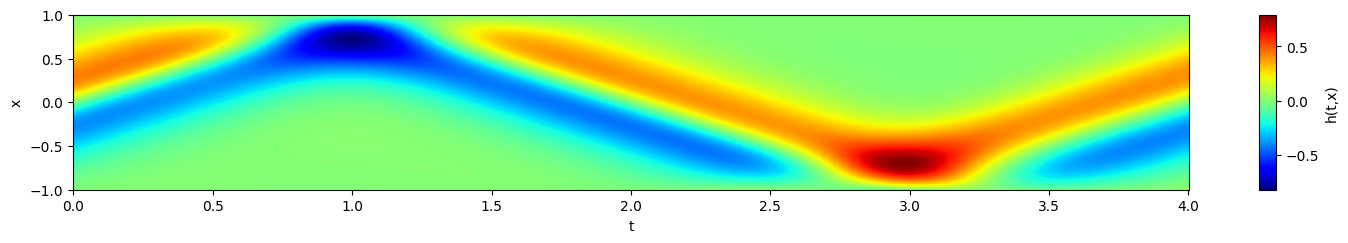

In [10]:
plot_solution(model, t_start, t_end, x_start, x_end, num_test_samples=1001)

# Burgers' Equation
We want to solve the one-dimensional Burgers' equation that is given by:
\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{equation}

We shall give the initial conditions $u(x, t=0)$ and $\frac{\partial u(x, t=0)}{\partial t}$ with Dirichlet boundary condition at $x = -1,+1$. The PINN model should predicts $u(x, t)$ for the input $(x, t)$.

Here, the chosen conditions are,
$$
\begin{aligned}
u(-1, t) & =0 \\
u(1, t) & =0 \\
u(x, 0) & =-sin(\pi x)
\end{aligned}
$$

where $u(0, x)=sin(\pi x)$, and $\frac{\partial u(x, t)}{\partial t}$ is the derivative of $u(x, t)$ with respect to $t$ that is evaluated at $t=0$.

The viscosity $\nu$ is set to $0.01/\pi$.

In [11]:
def burgers_equation(u,du_dx,du_dt,du_dxx,du_dtt):
    nu = 0.01/np.pi
    left = du_dt + u * du_dx
    right = nu * du_dxx
    return left,right

## Generate Data

In [12]:
# Constants
x_start = -1
x_end = 1
t_start = 0
t_end = 1

In [13]:
def f0(X_ic):
    x ,t = X_ic[:,0], X_ic[:,1]
    y_0 = -torch.sin(np.pi * x)
    return y_0

In [14]:
N_0 = 10000
N_b = 10000
N_f = 10000
X,bc,ic,y_bc,y_ic,dy_ic_dx = generate_data(N_0, N_b, N_f,f0=f0, x_start=x_start, x_end=x_end, t_start=t_start, t_end=t_end, dy_ic_dx = True)
print(f"X shape: {X.shape}," "\n"
      f"bc shape: {bc.shape}," "\n"
      f"ic shape: {ic.shape}," "\n"
      f"y_bc shape: {y_bc.shape}," "\n"
      f"y_ic shape: {y_ic.shape}" "\n"
      )

X shape: torch.Size([10000, 2]),
bc shape: torch.Size([10000, 2]),
ic shape: torch.Size([10000, 2]),
y_bc shape: torch.Size([10000]),
y_ic shape: torch.Size([10000])


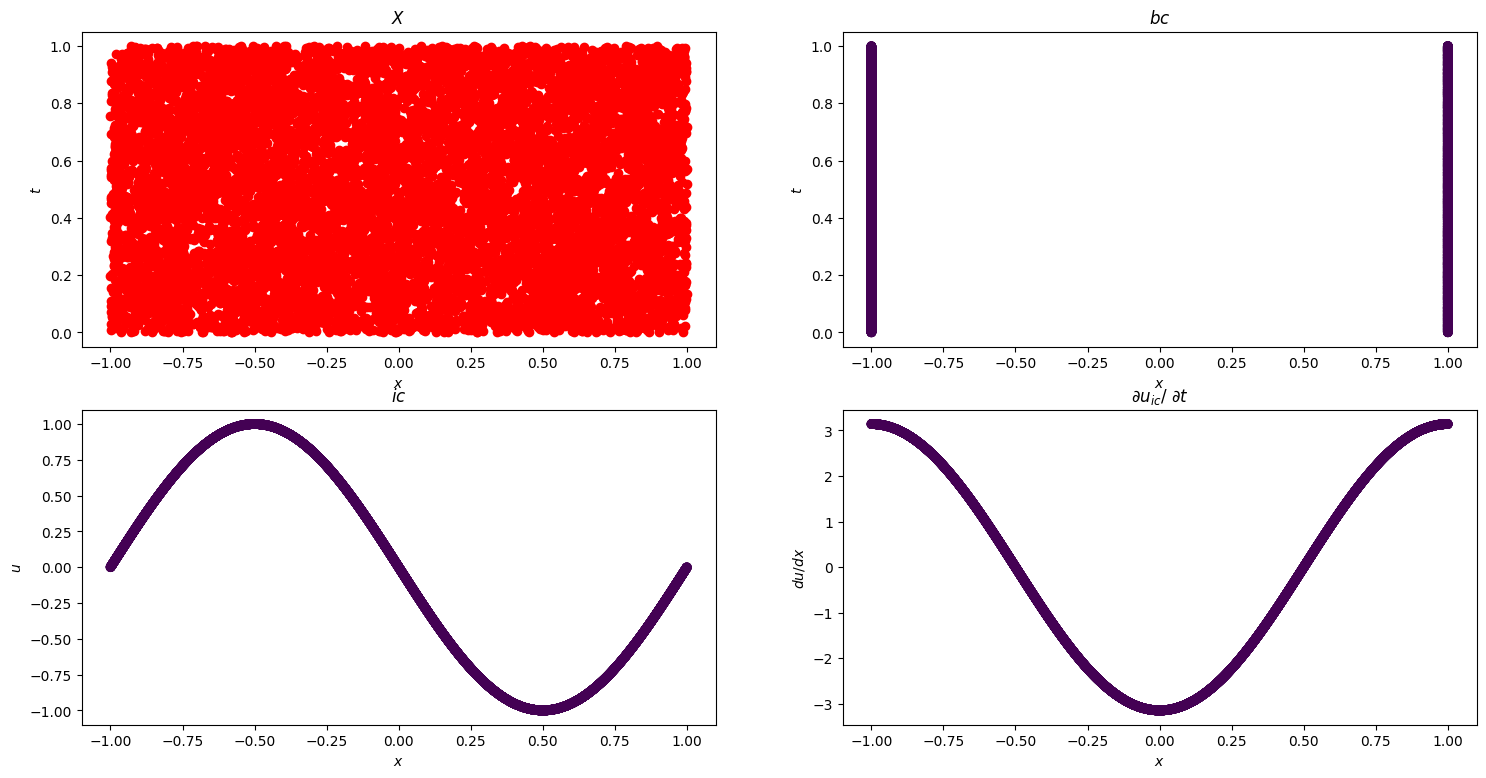

In [15]:
f = plot_data(X, bc, y_bc, ic, y_ic, dy_ic_dx)

## Train the model

In [16]:
trainer = Trainer(model= PINN([20,20,20,20],
                          lb= torch.tensor([x_start, t_start]),
                          ub= torch.tensor([x_end, t_end])),
            X = X,
            X_bc = bc,
            X_ic = ic,
            y_bc = y_bc,
            y_ic = y_ic,
            pde = burgers_equation,
            dy_ic_dx = None,
            )

In [17]:
history = trainer.train(adam_epochs=1000, lbfgs_epochs=5000)

Iteration: 100, Loss: 0.22621171176433563 , Loss BC: 0.03718394786119461, Loss IC: 0.1702107936143875, Loss PDE: 0.018816960975527763
Iteration: 200, Loss: 0.14708799123764038 , Loss BC: 0.008814132772386074, Loss IC: 0.08259571343660355, Loss PDE: 0.05567813664674759
Iteration: 300, Loss: 0.12761695683002472 , Loss BC: 0.0061257691122591496, Loss IC: 0.07233952730894089, Loss PDE: 0.04915165901184082
Iteration: 400, Loss: 0.11255814880132675 , Loss BC: 0.0036327482666820288, Loss IC: 0.06523166596889496, Loss PDE: 0.04369373619556427
Iteration: 500, Loss: 0.09813617169857025 , Loss BC: 0.0013367807259783149, Loss IC: 0.05620766431093216, Loss PDE: 0.04059172421693802
Iteration: 600, Loss: 0.09333021193742752 , Loss BC: 0.0008755568414926529, Loss IC: 0.052811577916145325, Loss PDE: 0.03964307904243469
Iteration: 700, Loss: 0.08973732590675354 , Loss BC: 0.0006236139452084899, Loss IC: 0.051172226667404175, Loss PDE: 0.03794148564338684
Iteration: 800, Loss: 0.08598257601261139 , Loss 

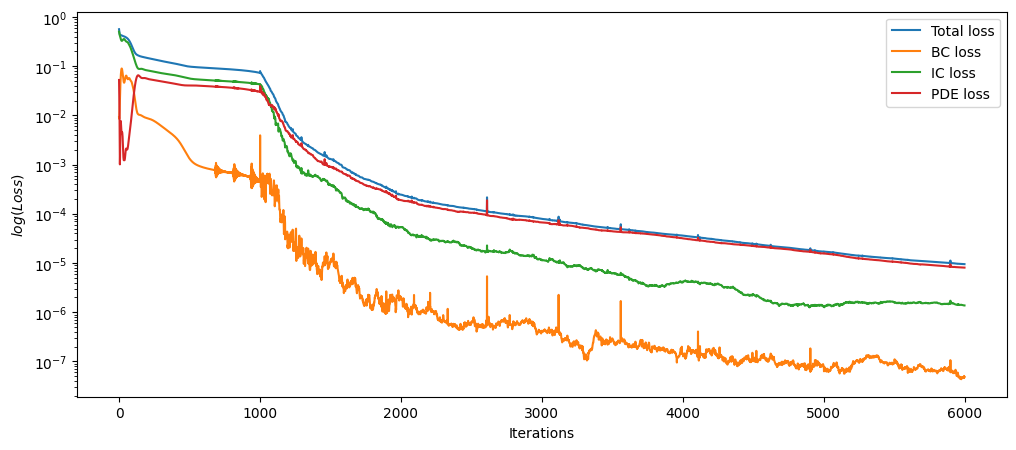

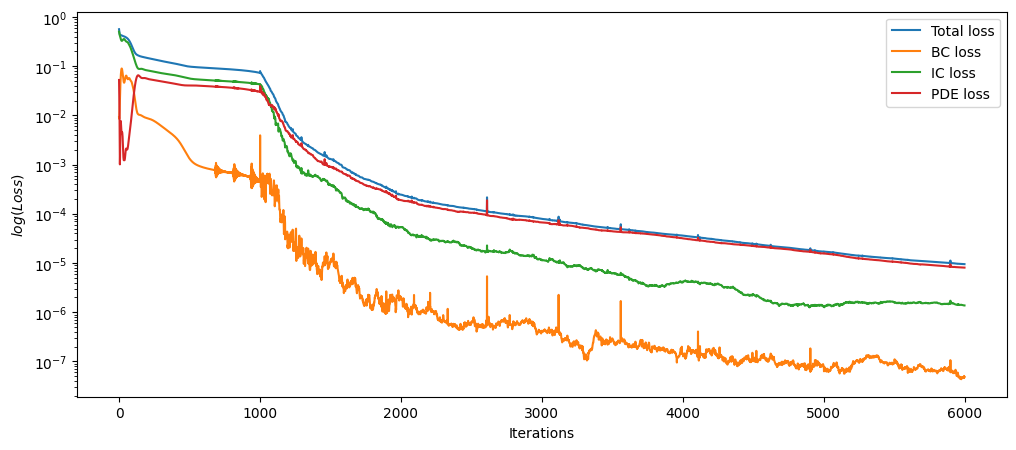

In [18]:
plot_learning_curve(history)

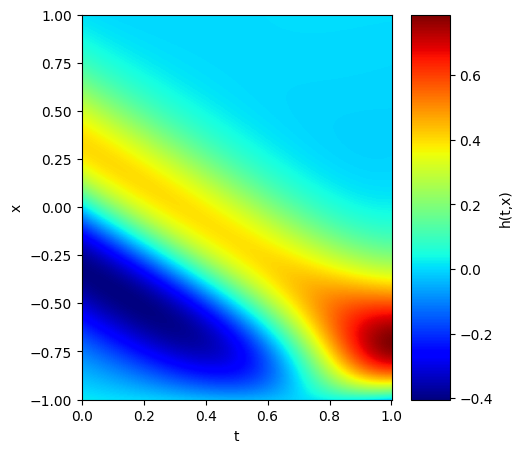

In [19]:
num_test_samples = 1001
t_flat = np.linspace(t_start, t_end, num_test_samples)
x_flat = np.linspace(x_start, x_end, num_test_samples)
x, t = np.meshgrid(x_flat, t_flat)
xt = np.stack([x.flatten(), t.flatten()], axis=-1)

u = model(xt).cpu().detach().numpy()
u = u.reshape(t.shape)

# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(5, 5))
#gs = GridSpec(2, 3)
#plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('h(t,x)')
